In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate

In [2]:
k2 = pd.read_csv(
    "./data/k2_planets_candidates.csv",
    comment='#',
    engine='python'
)
koi = pd.read_csv(
    "./data/koi.csv",
    comment='#',
    engine='python'
)
toi = pd.read_csv(
    "./data/toi.csv",
    comment='#',
    engine='python'
)

In [ ]:
"""
koi_score --> Probabilidad de que un candidato sea un exoplaneta real (lo calculó el equipo Kepler con su propio modelo).
koi_disposition: Estado del candidato (CONFIRMED/CANDIDATE/FALSE POSITIVE)
---------------------------
1. Atributos orbitales:

koi_period --> Período orbital del candidato en días.

koi_time0bk / koi_time0 --> Tiempo central del tránsito (época de tránsito).

koi_eccen --> Excentricidad orbital (qué tan alargada es la órbita de un cuerpo espacial).

koi_period_err1/2: Incertidumbre del período orbital (superior/inferior). ??

---------------------------
2. Atributos del tránsito:

koi_duration: Duración del tránsito en horas.

koi_depth: Profundidad del tránsito en partes por millón (ppm).

koi_impact: Parámetro de impacto (distancia del centro del disco estelar en unidades de radio estelar).

koi_prad: Radio estimado del planeta en radios terrestres.

koi_insol: Insolación recibida por el planeta en unidades de flujo terrestre.

koi_teq: Temperatura de equilibrio estimada del planeta (K).

koi_model_snr: Relación señal/ruido del modelo de tránsito.

---------------------------
3. Atributos del sistema solar:

koi_srad: Radio estelar (en radios solares).

koi_smass: Masa estelar (en masas solares).

koi_steff: Temperatura efectiva de la estrella (K).

koi_smet: Metalicidad de la estrella ([Fe/H]).

koi_slogg: Gravedad superficial de la estrella (cgs).

---------------------------
"""

### 1st step before EDA: train-test division.

In [4]:
koi.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200


In [5]:
print(koi.describe(), "\n")
print(koi.dtypes)

             rowid         kepid    koi_score  koi_fpflag_nt  koi_fpflag_ss  \
count  9564.000000  9.564000e+03  8054.000000    9564.000000    9564.000000   
mean   4782.500000  7.690628e+06     0.480829       0.208595       0.232748   
std    2761.033321  2.653459e+06     0.476928       4.767290       0.422605   
min       1.000000  7.574500e+05     0.000000       0.000000       0.000000   
25%    2391.750000  5.556034e+06     0.000000       0.000000       0.000000   
50%    4782.500000  7.906892e+06     0.334000       0.000000       0.000000   
75%    7173.250000  9.873066e+06     0.998000       0.000000       0.000000   
max    9564.000000  1.293514e+07     1.000000     465.000000       1.000000   

       koi_fpflag_co  koi_fpflag_ec     koi_period  koi_period_err1  \
count    9564.000000    9564.000000    9564.000000      9110.000000   
mean        0.197512       0.120033      75.671358         0.002148   
std         0.398142       0.325018    1334.744046         0.008236   
min 

In [6]:
features_of_interest = [
    # Probabilidad / etiqueta
    "koi_score",          # Probabilidad de que un candidato sea un exoplaneta real
    "koi_disposition",    # Estado del candidato: CONFIRMED / CANDIDATE / FALSE POSITIVE
    
    # Atributos orbitales
    "koi_period",         # Período orbital del candidato en días
    "koi_time0bk",        # Época de tránsito (tiempo central)
    "koi_time0",          # Otra referencia temporal del tránsito
    "koi_eccen",          # Excentricidad orbital
    "koi_period_err1",    # Incertidumbre superior del período orbital
    "koi_period_err2",    # Incertidumbre inferior del período orbital
    
    # Atributos del tránsito
    "koi_duration",       # Duración del tránsito en horas
    "koi_depth",          # Profundidad del tránsito (ppm)
    "koi_impact",         # Parámetro de impacto del tránsito
    "koi_prad",           # Radio estimado del planeta en radios terrestres
    "koi_insol",          # Insolación recibida por el planeta (flujo terrestre)
    "koi_teq",            # Temperatura de equilibrio estimada del planeta (K)
    "koi_model_snr",      # Relación señal/ruido del modelo de tránsito
    
    # Atributos del sistema estelar
    "koi_srad",           # Radio estelar (en radios solares)
    "koi_smass",          # Masa estelar (en masas solares)
    "koi_steff",          # Temperatura efectiva de la estrella (K)
    "koi_smet",           # Metalicidad de la estrella ([Fe/H])
    "koi_slogg"           # Gravedad superficial de la estrella (cgs)
]


In [7]:
reduced_koi = koi[features_of_interest]

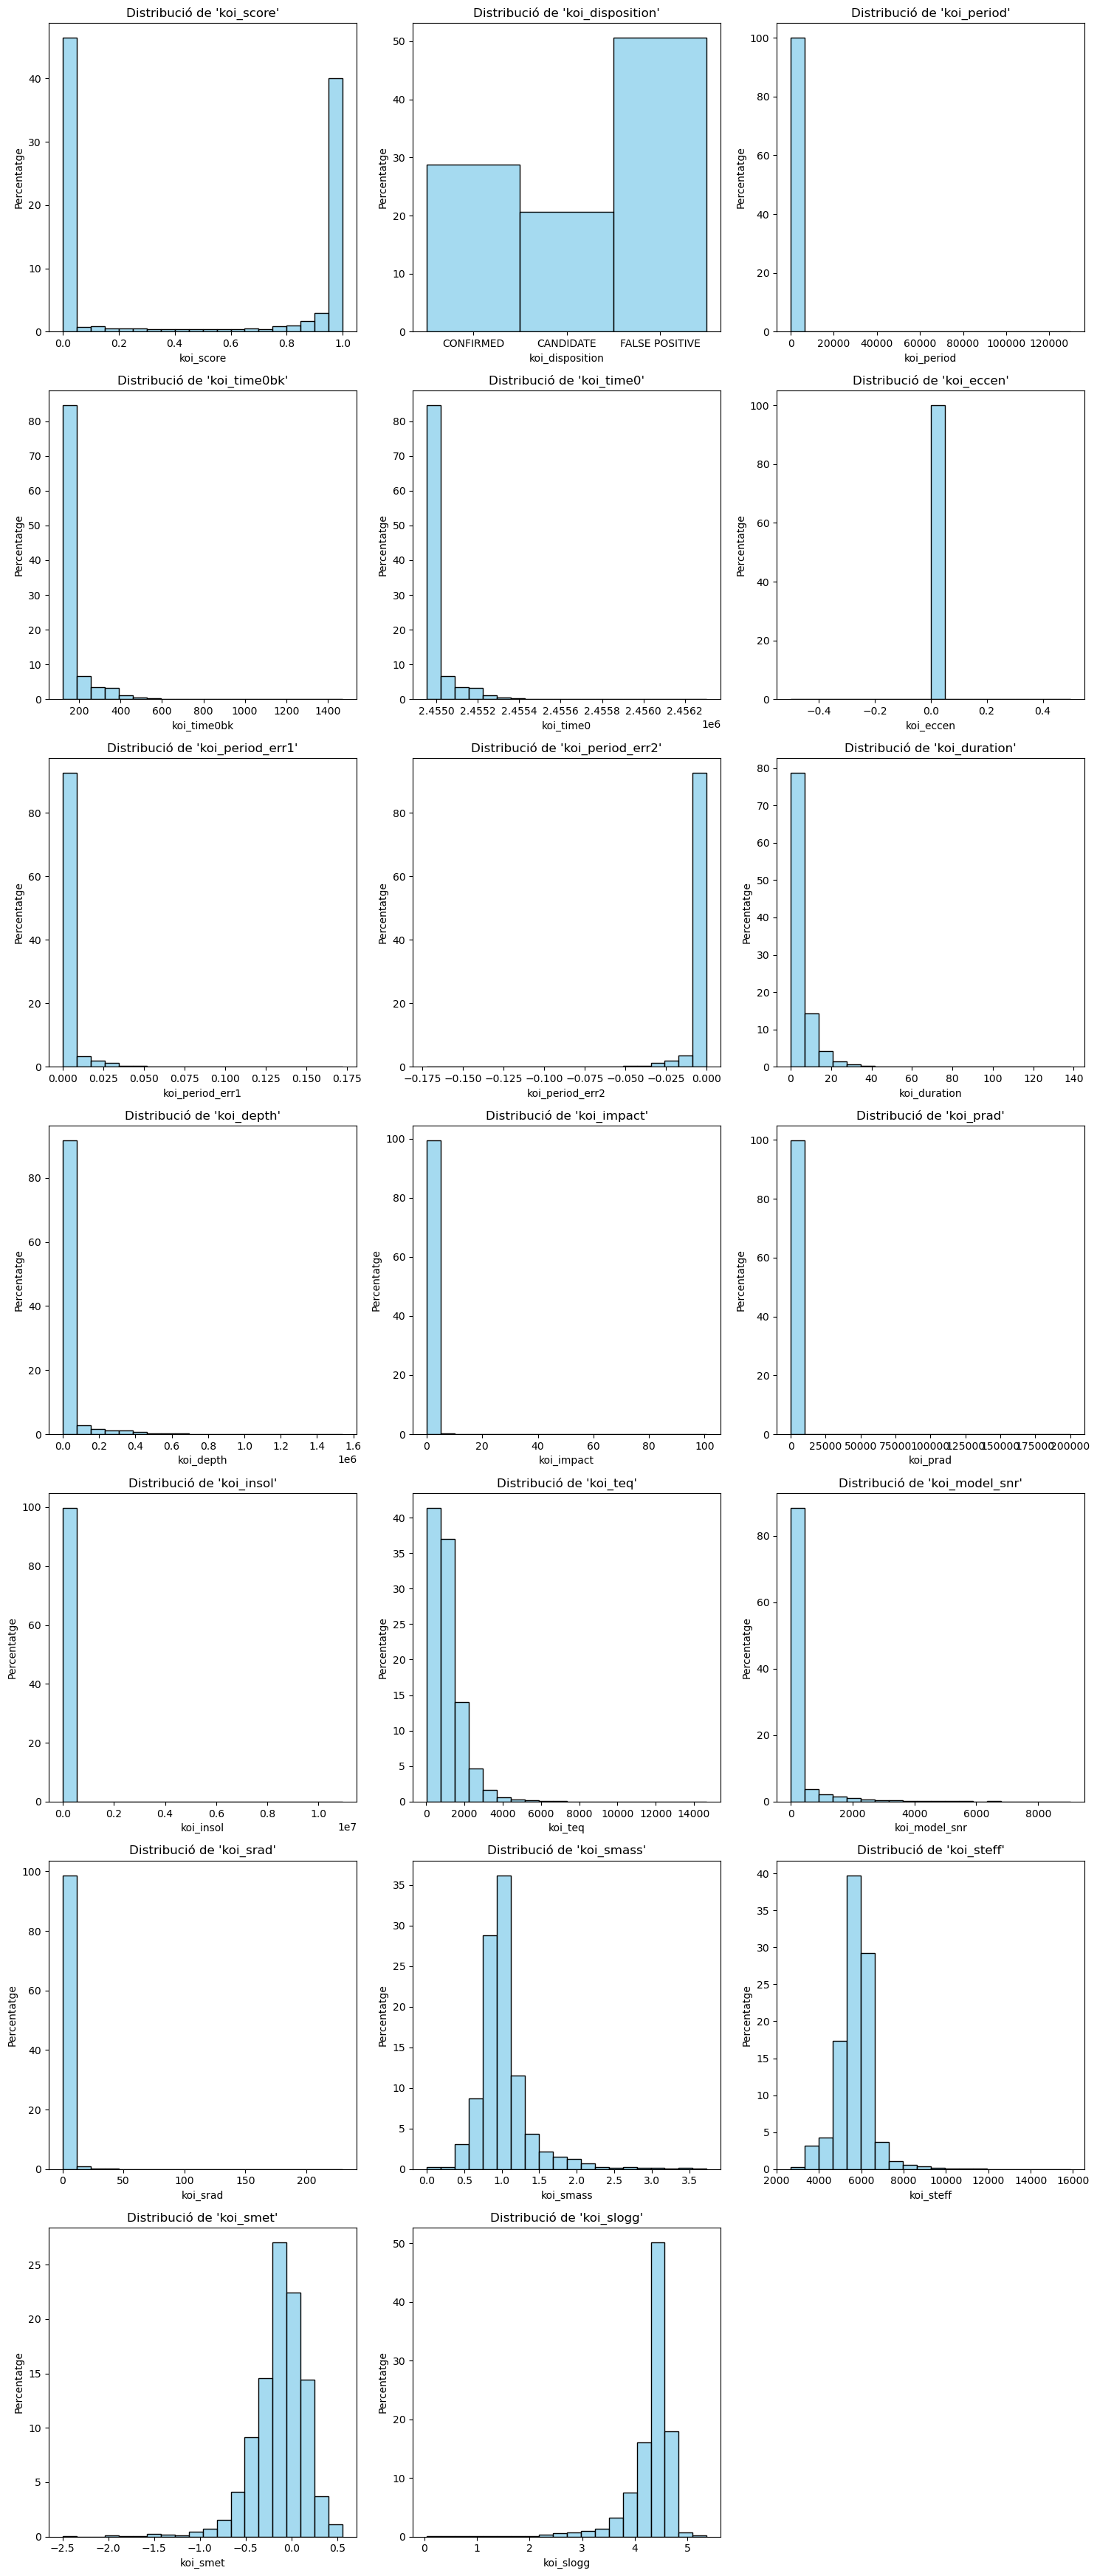

In [8]:
n_cols = 3
n_rows = len(reduced_koi.columns) // n_cols + (len(reduced_koi.columns) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, column in enumerate(reduced_koi.columns):
    sns.histplot(reduced_koi[column], kde=False, bins=20, stat="percent", color='skyblue', edgecolor='black', ax=axes[i])
    axes[i].set_title(f"Distribució de '{column}'")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Percentatge")

for i in range(len(reduced_koi.columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()
fig.savefig("distribuciones_koi.png", dpi=300, bbox_inches='tight')

### Important! "koi_eccen" column has no value other than 0.0 or NaN.

In [9]:
np.unique(reduced_koi["koi_eccen"])

array([ 0., nan])

### Important! Difference between "koi_disposition" y "koi_pdisposition" columns:

"koi_disposition" --> Exoplanet Archive Disposition. This is the OFFICIAL CLASSIFICATION that appears in the archive. Possible values: CANDIDATE, CONFIRMED, NOT DISPOSITIONED (not tested yet), FALSE POSITIVE.

"koi_pdisposition" --> Disposition Using Kepler Data. This is the PRELIMINAR CLASSIFICATION, obtained using Kepler data. Tries to explain the MOST PROBABLE state of each object of interest, although it MIGHT BE WRONG. Possible values: CANDIDATE, NOT DISPOSITIONED (not tested yet), FALSE POSITIVE.

Notice the example shown below, which shows objects marked as CONFIRMED by "koi_disposition" but marked as "FALSE POSITIVE" by "koi_pdisposition". This is because these objects of interest were preliminary tested using Kepler Data, and failed one or more tests, but there were later confirmed by a further examination.

Note: It would be pretty reasonable to eliminate "koi_pdisposition" column, as it might introduce noise and bias to our models, and only work with the official classification ("koi_disposition") as a target.

In [10]:
koi[(koi["koi_pdisposition"]=="FALSE POSITIVE") & (koi["koi_disposition"]=="CONFIRMED")]

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
274,275,11449844,K00125.01,Kepler-468 b,CONFIRMED,Done,2018-08-16,FALSE POSITIVE,0.920,0,...,-0.014,0.067,0.014,0.067,0.043,0.068,-0.347,0.073,0.349,0.073
519,520,11974540,K00129.01,Kepler-470 b,CONFIRMED,Done,2018-08-16,FALSE POSITIVE,1.000,0,...,0.127,0.072,0.233,0.071,-0.005,0.072,0.016,0.079,0.017,0.078
778,779,7532973,K01450.01,Kepler-854 b,CONFIRMED,Done,2018-08-16,FALSE POSITIVE,0.041,0,...,0.116,0.067,0.128,0.067,0.011,0.067,0.069,0.068,0.070,0.068
953,954,11517719,K01416.01,Kepler-840 b,CONFIRMED,Done,2018-08-16,FALSE POSITIVE,0.920,0,...,-0.017,0.067,0.020,0.067,-0.059,0.067,-0.088,0.067,0.106,0.067
2210,2211,8478994,K00245.04,Kepler-37 e,CONFIRMED,Done,2018-08-16,FALSE POSITIVE,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2767,2768,10585738,K03032.01,Kepler-1415 b,CONFIRMED,Done,2018-08-16,FALSE POSITIVE,0.973,0,...,-0.420,0.540,0.500,0.620,0.130,0.410,-0.470,0.490,0.490,0.550
3043,3044,6444896,K03138.02,Kepler-1649 c,CONFIRMED,Done,2018-08-16,FALSE POSITIVE,0.374,1,...,0.220,0.410,0.280,0.920,-1.500,1.200,-0.990,0.370,1.800,1.100
3385,3386,4742414,K00631.01,Kepler-628 b,CONFIRMED,Done,2018-08-16,FALSE POSITIVE,0.999,0,...,0.001,0.081,0.006,0.076,0.004,0.074,0.103,0.083,0.103,0.083
7632,7633,4735826,K03184.02,Kepler-1972 c,CONFIRMED,Done,2018-08-16,FALSE POSITIVE,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### We will try to find the most important features through Random Forest's default feature classification method (Mean Decrese in Impurity)

Note: It is not necessary to normalize or preprocess the data in any way yet. Random Forests are not strongly affected by unprocessed data. It is only necessary to drop object (str) columns such as "kepoi_name" and "kepler_name" or ID columns. "koi_vet_date" (string indicating the date when the last parameter was updated) is also droppable.

In [15]:
non_numerical_features = koi.select_dtypes(include="object").columns.tolist()
non_numerical_features.extend(["rowid", "kepid"])
print(non_numerical_features)

['kepoi_name', 'kepler_name', 'koi_disposition', 'koi_vet_stat', 'koi_vet_date', 'koi_pdisposition', 'koi_disp_prov', 'koi_comment', 'koi_fittype', 'koi_limbdark_mod', 'koi_parm_prov', 'koi_tce_delivname', 'koi_quarters', 'koi_trans_mod', 'koi_datalink_dvr', 'koi_datalink_dvs', 'koi_sparprov', 'rowid', 'kepid']


### Importat! Further exploration could be done to non_numerical_features to see if they carry important information

In [16]:
X = koi.drop(non_numerical_features, axis=1)
y = koi["koi_disposition"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train.head()

,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
8117,0.000,1,0,1,1,0.580725,0.000004,-0.000004,131.72956,0.00663,...,2.760,0.510,3.020,0.480,-1.250,0.750,2.770,0.400,3.050,0.480
5245,0.997,0,0,0,0,14.532605,0.000044,-0.000044,140.46850,0.00238,...,0.360,0.280,0.360,0.280,0.050,0.280,0.690,0.280,0.690,0.280
5865,1.000,0,0,1,0,1.339670,0.000005,-0.000005,132.16786,0.00332,...,7.290,0.160,8.620,0.200,-4.416,0.098,7.620,0.100,8.800,0.110
4050,0.000,0,1,1,0,160.412202,0.000997,-0.000997,262.40022,0.00456,...,-6.613,0.088,6.736,0.087,1.353,0.075,-6.965,0.085,7.096,0.082
5130,0.996,0,0,0,0,11.937835,0.000174,-0.000174,133.26120,0.01290,...,1.000,0.480,1.070,0.480,-0.440,0.380,0.620,0.510,0.760,0.480


In [19]:
y_train.head()

8117    FALSE POSITIVE
5245         CONFIRMED
5865    FALSE POSITIVE
4050    FALSE POSITIVE
5130         CANDIDATE
Name: koi_disposition, dtype: object

In [20]:
RF = RandomForestClassifier()

cv_results = cross_validate(RF, X_train, y_train, cv=5, n_jobs=-1)

In [21]:
cv_results

{'fit_time': array([8.03602743, 8.04988837, 7.91963053, 7.87790871, 7.75593257]),
 'score_time': array([0.0368669 , 0.04217863, 0.03848028, 0.03970289, 0.03918433]),
 'test_score': array([0.9268452 , 0.9379085 , 0.93529412, 0.93267974, 0.91960784])}

In [22]:
RF.fit(X_train, y_train)
feature_importances = {feature: importance for feature, importance in zip(X_train.columns, RF.feature_importances_)}
feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

In [25]:
print("Features ordered by importance, according to default Random Forest\n")
for feature, importance in feature_importances.items(): print(f"{feature}: {importance}")

Features ordered by importance, according to default Random Forest

koi_score: 0.13406108253705015
koi_fpflag_nt: 0.06313533901185026
koi_max_mult_ev: 0.04855365894607156
koi_dicco_msky: 0.035783826688989856
koi_fpflag_ss: 0.03022632800026147
koi_fpflag_co: 0.02964262210601635
koi_prad: 0.027378812063008705
koi_dikco_msky: 0.02294080586455029
koi_smet_err2: 0.02250524245330766
koi_fwm_stat_sig: 0.021634880045668714
koi_ror: 0.021520232566486042
koi_model_snr: 0.01943253733289016
koi_prad_err2: 0.016598309303306347
koi_fpflag_ec: 0.015290859172228935
koi_dikco_msky_err: 0.014893779653548761
koi_duration_err2: 0.014129842104099075
koi_fwm_sra_err: 0.013223822987732146
koi_prad_err1: 0.0126158369565595
koi_steff_err2: 0.011665937193059837
koi_dor: 0.011482540201786122
koi_fwm_sdeco_err: 0.0108927723926843
koi_fwm_sdec_err: 0.010722808641315373
koi_dikco_mra_err: 0.010697897139070996
koi_time0bk_err1: 0.010272598924201744
koi_steff_err1: 0.009984633530251207
koi_dicco_msky_err: 0.009537130

Let's now focus on target's distribution ("koi_disposition").

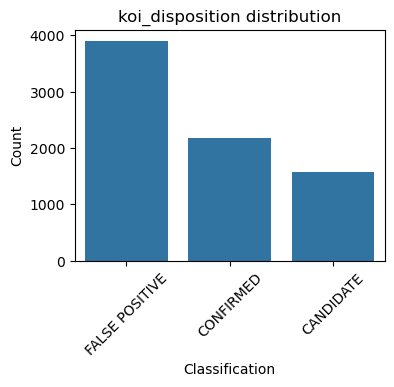

Counts:
koi_disposition
FALSE POSITIVE    3900
CONFIRMED         2177
CANDIDATE         1574
Name: count, dtype: int64

Proportions:
koi_disposition
FALSE POSITIVE    0.509737
CONFIRMED         0.284538
CANDIDATE         0.205725
Name: proportion, dtype: float64


In [26]:
def showTargetDistribution(target):
    if not isinstance(target, pd.Series):
        raise ValueError("Target must be a pd.Series")
    
    classes = target.unique()
    
    plt.figure(figsize=(max(4, len(classes)), 3))
    sns.countplot(x=target, order=classes)
    plt.title(f'{target.name} distribution')
    plt.ylabel('Count')
    plt.xlabel('Classification')
    plt.xticks(rotation=45)
    plt.show()
    
    counts = target.value_counts()
    proportions = target.value_counts(normalize=True)
    
    print("Counts:")
    print(counts)
    print("\nProportions:")
    print(proportions)
    
showTargetDistribution(y_train)

We clearly see unbalanced classes. Balance might be helpful (SMOTENC?).